# Looking at genre popularity

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
### MOVIE DATABASES ###

# Box Office Mojo by IMDb Pro
movie_gross_df = pd.read_csv('../data/zippedData/bom.movie_gross.csv.gz')

# IMDb
imdb_name_df = pd.read_csv('../data/zippedData/imdb.name.basics.csv.gz')
imdb_akas_df = pd.read_csv('../data/zippedData/imdb.title.akas.csv.gz')
imdb_basics_df = pd.read_csv('../data/zippedData/imdb.title.basics.csv.gz')
imdb_crew_df = pd.read_csv('../data/zippedData/imdb.title.crew.csv.gz')
imdb_principals_df = pd.read_csv('../data/zippedData/imdb.title.principals.csv.gz')
imdb_ratings_df = pd.read_csv('../data/zippedData/imdb.title.ratings.csv.gz')

# Rotten Tomatos
rt_movies_df = pd.read_csv('../data/zippedData/rt.movie_info.tsv.gz', sep='\t')
rt_reviews_df = pd.read_csv('../data/zippedData/rt.reviews.tsv.gz', sep='\t', encoding= 'unicode_escape')

# The Movie Database
tmdb_movies_df = pd.read_csv('../data/zippedData/tmdb.movies.csv.gz')

# The Numbers
tn_budgets_df = pd.read_csv('../data/zippedData/tn.movie_budgets.csv.gz')

### IMDB Genres Ratings
We will start by joinning the imdb_basics_df to the imdb_ratings_df.

In [3]:
imdb_basics_rating = pd.merge(left=imdb_basics_df,right=imdb_ratings_df,
                               on='tconst',how='inner')

In [4]:
imdb_basics_rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 5.1+ MB


The metadata on imdb_basics_rating shows us that the genre column is among the columns with missing values. Since the genres column is the column of interest for our investigation, we will need to drop rows with missing genre values.

### Dropping rows with missing genres

In [5]:
imdb_basics_rating = imdb_basics_rating[imdb_basics_rating['genres'].isna() != True]

In [6]:
imdb_basics_rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73052 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           73052 non-null  object 
 1   primary_title    73052 non-null  object 
 2   original_title   73052 non-null  object 
 3   start_year       73052 non-null  int64  
 4   runtime_minutes  65720 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73052 non-null  float64
 7   numvotes         73052 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 5.0+ MB


### Extracting The Genres And Ratings From The IMDB DataFrame

In [7]:
imdb_basics_rating.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


Notice that there are movies that fall into multiple genre categories. We want to create a genres column that holds the individual genre categories in order to be able to group our data by genres and find the average rating per genre. For each movie that has multiple movie genres, we will grab each individual genre and pair it up with the same rating that it was assigned for that same movie. 

In [8]:
genres_ratings_1 = imdb_basics_rating[['genres','averagerating']]
genres = list(genres_ratings_1['genres'].values)
ratings = list(genres_ratings_1['averagerating'].values)

In [9]:
x = []
for genre, rating in zip(genres,ratings):
    if ',' in genre:
        g_list = str(genre).split(',')
        for element in g_list:
            x.append((element,rating))
    else:
        x.append((genre,rating))

In [10]:
genre_list = [y[0] for y in x]
ratings_list = [y[1] for y in x]

genres_ratings_1 = pd.DataFrame([genre_list,ratings_list]).T
genres_ratings_1.columns = ['genre','ratings']
genres_ratings_1['ratings'] = genres_ratings_1['ratings'].astype(float)
genres_ratings_1['genre'].value_counts()

Drama          30788
Documentary    17753
Comedy         17290
Thriller        8217
Horror          7674
Action          6988
Romance         6589
Crime           4611
Adventure       3817
Biography       3809
Family          3412
Mystery         3039
History         2825
Sci-Fi          2206
Fantasy         2126
Music           1968
Animation       1743
Sport           1179
War              853
Musical          721
News             579
Western          280
Reality-TV        17
Adult              3
Game-Show          2
Short              1
Name: genre, dtype: int64

The genres with fewer observations will be omitted as they do not have sufficient observations to be able to compare their rating average to genres with many observations. We will limit ourselves to genres that have a count of at least 2000.

In [11]:
not_include = ['Short','Game-Show','Adult','Reality-TV','Western','News','Musical','War','Sport','Animation','Music']

for row in genres_ratings_1['genre']:
    if row in not_include:
        genres_ratings_1 = genres_ratings_1[genres_ratings_1['genre'] != row]

In [12]:
genres_ratings_1['genre'].value_counts()

Drama          30788
Documentary    17753
Comedy         17290
Thriller        8217
Horror          7674
Action          6988
Romance         6589
Crime           4611
Adventure       3817
Biography       3809
Family          3412
Mystery         3039
History         2825
Sci-Fi          2206
Fantasy         2126
Name: genre, dtype: int64

### Grouping by Genre and finding the average Rating for each Genre

In [13]:
imdb_average_ratings = genres_ratings_1.groupby('genre').mean()
imdb_average_ratings

,ratings
genre,
Action,5.810361
Adventure,6.196201
Biography,7.162274
Comedy,6.002689
Crime,6.115441
Documentary,7.332090
Drama,6.401559
Family,6.394725
Fantasy,5.919473


In [14]:
imdb_average_ratings = imdb_average_ratings.sort_values(by='ratings')
imdb_average_ratings

,ratings
genre,
Horror,5.003440
Sci-Fi,5.489755
Thriller,5.639114
Action,5.810361
Fantasy,5.919473
Mystery,5.920401
Comedy,6.002689
Crime,6.115441
Romance,6.146608


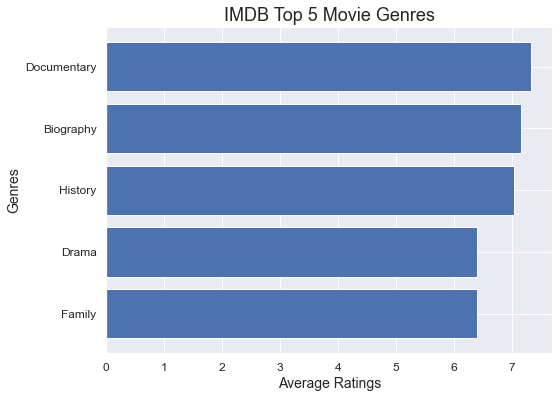

In [30]:
imdb_genres = list(imdb_average_ratings.index)[10:]
imdb_ratings = [z[0] for z in imdb_average_ratings.values][10:]

fig, ax = plt.subplots(figsize=(8,6))
ax.barh(imdb_genres,imdb_ratings)
ax.set_title('IMDB Top 5 Movie Genres',fontdict={'fontsize':18})
ax.set_xlabel('Average Ratings',fontdict={'fontsize':14})
ax.set_ylabel('Genres',fontdict={'fontsize':14})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

### Looking at Rotten Tomatoes Genre Ratings
We will perform the similar process as we did for the imdb genre and ratings data.

In [16]:
rt_reviews_df.dropna(inplace=True)
joinedrt = rt_movies_df.set_index('id').join(rt_reviews_df, on = 'id', lsuffix = ' guidelines', rsuffix =' critical')
joinedrt = joinedrt.dropna(subset = ['runtime'])
joinedrt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1530 entries, 1 to 2000
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   synopsis           1485 non-null   object 
 1   rating guidelines  1530 non-null   object 
 2   genre              1526 non-null   object 
 3   director           1345 non-null   object 
 4   writer             1100 non-null   object 
 5   theater_date       1194 non-null   object 
 6   dvd_date           1194 non-null   object 
 7   currency           338 non-null    object 
 8   box_office         338 non-null    object 
 9   runtime            1530 non-null   object 
 10  studio             489 non-null    object 
 11  id                 933 non-null    float64
 12  review             933 non-null    object 
 13  rating critical    933 non-null    object 
 14  fresh              933 non-null    object 
 15  critic             933 non-null    object 
 16  top_critic         933 n

In [17]:
joinedrt['freshnum'] = joinedrt['fresh'].map({'fresh': 1, 'rotten': 0})

joinedrt['rating critical'] = joinedrt['rating critical'].replace({'3/4' : 75, '4/5' : 80, '3/5' : 60, '1/4': 25, '1/5': 20,'3.5/4' : 87, '2/5': 40, '2/4': 50, '3.7/5': 74})
joinedrt['rating critical'] = joinedrt['rating critical'].replace({'2.5/4': 63, '3.5/5' : 70, '5/5': 100, 'B': 85, '4/4': 100, 'B+': 88, "A-": 93, '2.5/5' : 50, "8/10" : 80, 'B-': 82, '4.5/5': 90, '1.5/4': 37.5, 'A': 95, '6/10': 60, 'C+': 77, '9/10': 90, "C": 74, 'C-': 72, '5/10': 50, '1.5/5': 30, '7/10': 70})
joinedrt['rating critical'] = joinedrt['rating critical'].replace({'0/5':0, '8': 80, '1': 10, '4/10': 40, 'D+': 69, '7': 70, '3/10': 30, 'D': 67, "0.5/4": 13, '6': 60})
joinedrt['rating critical'] = joinedrt['rating critical'].replace({"3": 30, "D-": 66, "1/10": 10, '0/4' : 0, '8.5/10': 85, "A+": 98, '4.0/4': 100, "8.4/10": 84, "9": 90, "F": 35, "7.5/10": 75, "7.7": 77, "2": 20, "0": 0, "2.0/5": 40, '0.5/10': 5})
joinedrt['rating critical'] = joinedrt['rating critical'].replace({'2/10': 20, '5.0/5': 100, '3.0/5': 60, "2.5": 50, '5': 50, '2.2/5': 44})

In [18]:
joinedrt['rating critical'].value_counts()

75.0     122
80.0     113
60.0      85
100.0     76
50.0      76
87.0      74
63.0      46
40.0      44
70.0      41
85.0      33
88.0      29
90.0      24
93.0      22
95.0      16
20.0      15
37.5      15
82.0      14
74.0      13
30.0      13
77.0      13
25.0      11
72.0      11
10.0       6
0.0        6
69.0       4
84.0       2
67.0       2
98.0       2
13.0       2
44.0       1
5.0        1
35.0       1
Name: rating critical, dtype: int64

In [19]:
joinedrt['rating critical'] = joinedrt['rating critical']/10

In [20]:
genres_ratings_2 = joinedrt[['genre','rating critical']]
genres = list(genres_ratings_2['genre'].values)
ratings = list(genres_ratings_2['rating critical'].values)

In [22]:
x = []
for tup in list(zip(genres,ratings)):
    if '|' in str(tup[0]):
        lis = str(tup[0]).split('|')
        for element in lis:
            x.append((element,tup[1]))
    else:
        x.append(tup)

In [23]:
rt_genre_list = [y[0] for y in x]
rt_ratings_list = [y[1] for y in x]

rt_genres_ratings = pd.DataFrame([rt_genre_list,rt_ratings_list]).T
rt_genres_ratings.columns = ['genre','ratings']
rt_genres_ratings['ratings'] = rt_genres_ratings['ratings'].astype(float)

In [24]:
rt_genres_ratings['genre'].value_counts()

Drama                          903
Comedy                         545
Action and Adventure           357
Mystery and Suspense           306
Art House and International    260
Romance                        198
Classics                       193
Science Fiction and Fantasy    169
Horror                         130
Kids and Family                 97
Musical and Performing Arts     97
Documentary                     67
Special Interest                58
Western                         48
Animation                       47
Television                      23
Faith and Spirituality          11
Sports and Fitness               8
Cult Movies                      4
Anime and Manga                  2
Gay and Lesbian                  2
Name: genre, dtype: int64

In [25]:
include = ['Drama','Comedy','Action and Adventure','Mystery and Suspense','Art House and International', 'Romance','Classics','Science Fiction and Fantasy']

for row in rt_genres_ratings['genre']:
    if row not in include:
        rt_genres_ratings = rt_genres_ratings[rt_genres_ratings['genre'] != row]

In [26]:
rt_genres_ratings['genre'].value_counts()

Drama                          903
Comedy                         545
Action and Adventure           357
Mystery and Suspense           306
Art House and International    260
Romance                        198
Classics                       193
Science Fiction and Fantasy    169
Name: genre, dtype: int64

In [27]:
rt_average_ratings = rt_genres_ratings.groupby('genre').mean()
rt_average_ratings = rt_average_ratings.sort_values(by='ratings')
rt_average_ratings

,ratings
genre,
Romance,6.986250
Comedy,7.010152
Drama,7.053880
Action and Adventure,7.062723
Art House and International,7.067791
Science Fiction and Fantasy,7.071429
Classics,7.116129
Mystery and Suspense,7.213158


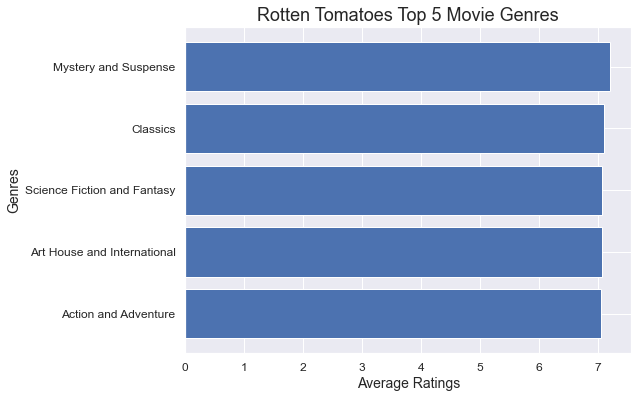

In [29]:
rt_genres = list(rt_average_ratings.index)[3:]
rt_ratings = [z[0] for z in rt_average_ratings.values][3:]

fig, ax = plt.subplots(figsize=(8,6))
ax.barh(rt_genres,rt_ratings)
ax.set_title('Rotten Tomatoes Top 5 Movie Genres',fontdict={'fontsize':18})
ax.set_xlabel('Average Ratings', fontdict={'fontsize': 14})
ax.set_ylabel('Genres',fontdict={'fontsize':14})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);